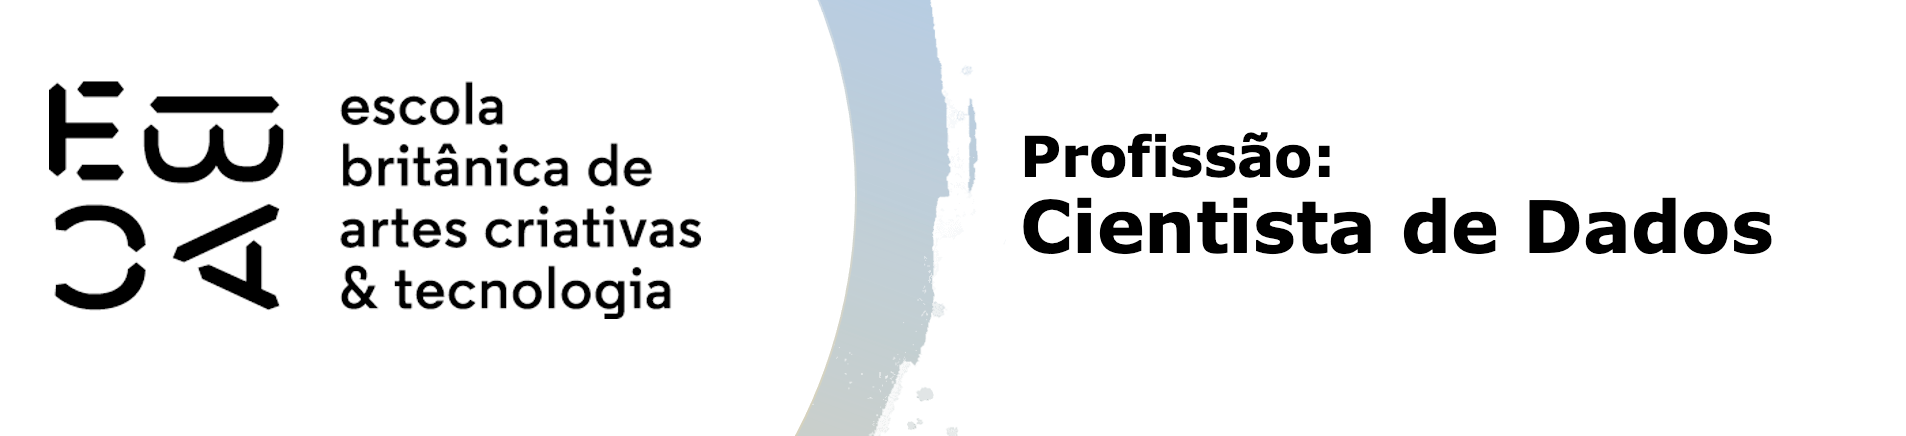

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from scipy.stats import t
from scipy.stats import ks_2samp

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [4]:
print('numero de linhas: {0} \nnúmero de colunas: {1}'.format(df.shape[0], df.shape[1]))
df.mau.value_counts(normalize=True)

numero de linhas: 750000 
número de colunas: 15


mau
False    0.921809
True     0.078191
Name: proportion, dtype: float64

In [5]:
df.mau.value_counts()

mau
False    691357
True      58643
Name: count, dtype: int64

In [6]:
df.isna().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [7]:
df = df.fillna(-1)

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [9]:
# Transformei o data_ref como datetime
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Meses únicos disponíveis
meses_disponiveis = df['data_ref'].sort_values().unique()
print("Meses disponíveis:", meses_disponiveis)

Meses disponíveis: <DatetimeArray>
['2015-01-01 00:00:00', '2015-02-01 00:00:00', '2015-03-01 00:00:00',
 '2015-04-01 00:00:00', '2015-05-01 00:00:00', '2015-06-01 00:00:00',
 '2015-07-01 00:00:00', '2015-08-01 00:00:00', '2015-09-01 00:00:00',
 '2015-10-01 00:00:00', '2015-11-01 00:00:00', '2015-12-01 00:00:00',
 '2016-01-01 00:00:00', '2016-02-01 00:00:00', '2016-03-01 00:00:00']
Length: 15, dtype: datetime64[ns]


In [10]:
# Separaçao da base OOT e a base de modelagem (treino/validação)
df_oot = df[df['data_ref'] >= '2016-01-01 00:00:00']
df_modelagem = df[df['data_ref'] < '2016-01-01 00:00:00']

print(f"Tamanho total: {df.shape[0]}")
print(f"Base de modelagem (treino/OOS): {df_modelagem.shape[0]}")
print(f"Base OOT (validação final): {df_oot.shape[0]}")

Tamanho total: 750000
Base de modelagem (treino/OOS): 600000
Base OOT (validação final): 150000


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [12]:
# Total de linhas
print("Número total de linhas:", df.shape[0])

# Número de linhas por mês em data_ref
print("Número de linhas por mês (safra):")
print(df['data_ref'].value_counts().sort_index())


Número total de linhas: 750000
Número de linhas por mês (safra):
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64


In [13]:
variaveis_quantitativas = ['qtd_filhos', 'idade', 'tempo_emprego',
                           'qt_pessoas_residencia', 'renda']

print("Estatísticas descritivas - Variáveis Quantitativas:")
df[variaveis_quantitativas].describe()

Estatísticas descritivas - Variáveis Quantitativas:


,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
count,750000.000000,750000.000000,750000.000000,750000.000000,7.500000e+05
mean,0.433251,43.804733,6.279315,2.212241,2.323854e+04
std,0.739379,11.229868,6.921453,0.903428,7.910601e+04
min,0.000000,22.000000,-1.000000,1.000000,1.076700e+02
25%,0.000000,34.000000,1.183562,2.000000,3.467700e+03
50%,0.000000,43.000000,4.690411,2.000000,7.861820e+03
75%,1.000000,53.000000,9.090411,3.000000,1.831828e+04
max,14.000000,68.000000,42.906849,15.000000,4.083986e+06


In [14]:
variaveis_qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel',
                          'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

iv_sexo = IV(df.sexo, df.mau)
iv_posse_de_veiculo = IV(df.posse_de_veiculo, df.mau)
iv_posse_de_imovel = IV(df.posse_de_imovel, df.mau)
iv_tipo_renda = IV(df.tipo_renda, df.mau)
iv_educacao = IV(df.educacao, df.mau)
iv_estado_civil = IV(df.estado_civil, df.mau)
iv_tipo_residencia = IV(df.tipo_residencia, df.mau)

print(f'IV da variável sexo: {iv_sexo:.1%}')
print(f'IV da variável posse_de_veiculo: {iv_posse_de_veiculo:.1%}')
print(f'IV da variável posse_de_imovel: {iv_posse_de_imovel:.1%}')
print(f'IV da variável tipo_renda: {iv_tipo_renda:.1%}')
print(f'IV da variável educacao: {iv_educacao:.1%}')
print(f'IV da variável estado_civil: {iv_estado_civil:.1%}')
print(f'IV da variável tipo_residencia: {iv_tipo_residencia:.1%}')

IV da variável sexo: 0.2%
IV da variável posse_de_veiculo: 0.0%
IV da variável posse_de_imovel: 1.0%
IV da variável tipo_renda: 0.9%
IV da variável educacao: 0.4%
IV da variável estado_civil: 0.1%
IV da variável tipo_residencia: 0.3%


In [15]:
# Transformei a variável resposta em inteiro
df['mau'] = df.mau.astype('int64')

# Criei metadados para melhor analise das variaveis
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
data_ref,datetime64[ns],0.0,15.0,covariavel
index,int64,0.0,16650.0,covariavel
sexo,object,0.0,2.0,covariavel
posse_de_veiculo,object,0.0,2.0,covariavel
posse_de_imovel,object,0.0,2.0,covariavel
qtd_filhos,int64,0.0,8.0,covariavel
tipo_renda,object,0.0,5.0,covariavel
educacao,object,0.0,5.0,covariavel
estado_civil,object,0.0,5.0,covariavel
tipo_residencia,object,0.0,6.0,covariavel


In [16]:
# Calculo do IV no metadados
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

    
metadados

,dtype,nmissing,valores_unicos,papel,IV
data_ref,datetime64[ns],0.0,15.0,covariavel,0.345982
index,int64,0.0,16650.0,covariavel,0.002664
sexo,object,0.0,2.0,covariavel,0.002185
posse_de_veiculo,object,0.0,2.0,covariavel,0.000108
posse_de_imovel,object,0.0,2.0,covariavel,0.009693
qtd_filhos,int64,0.0,8.0,covariavel,0.000030
tipo_renda,object,0.0,5.0,covariavel,0.009360
educacao,object,0.0,5.0,covariavel,0.003547
estado_civil,object,0.0,5.0,covariavel,0.001126
tipo_residencia,object,0.0,6.0,covariavel,0.003045


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [18]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

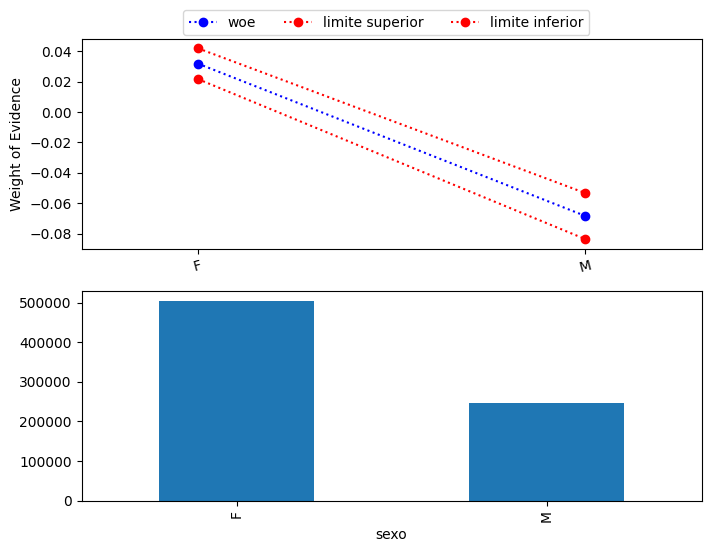

In [19]:
biv_discreta('sexo', df);

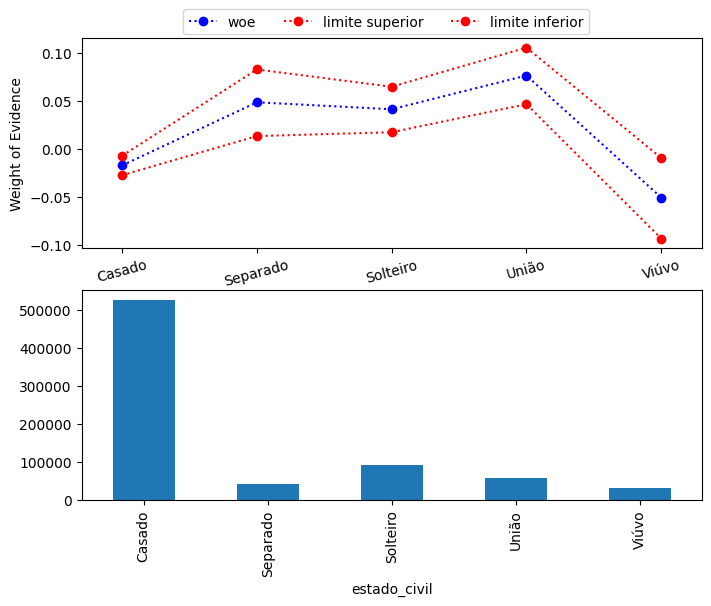

In [20]:
biv_discreta('estado_civil', df);

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,354527,31213,0.080917,Assalariado,385740,0.000439,0.081778,0.080057,-2.429950,-2.418434,-2.441578,0.037238,0.048754,0.025610
Bolsista,346,15,0.041551,Bolsista,361,0.010503,0.062207,0.020896,-3.138389,-2.713068,-3.847087,-0.671200,-0.245880,-1.379899
Empresário,159508,13204,0.076451,Empresário,172712,0.000639,0.077704,0.075198,-2.491574,-2.473957,-2.509458,-0.024386,-0.006769,-0.042270
Pensionista,115825,10440,0.082683,Pensionista,126265,0.000775,0.084202,0.081164,-2.406436,-2.386573,-2.426634,0.060752,0.080615,0.040555
Servidor público,61151,3771,0.058085,Servidor público,64922,0.000918,0.059884,0.056286,-2.786006,-2.753587,-2.819381,-0.318818,-0.286399,-0.352193


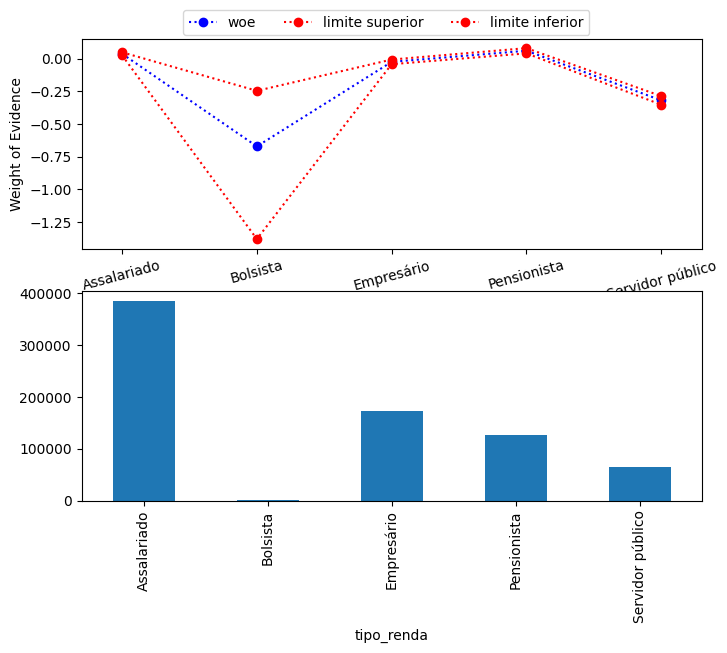

In [21]:
biv_discreta('tipo_renda', df)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,7789,786,0.091662,Fundamental,8575,0.003116,0.097770,0.085554,-2.293511,-2.222252,-2.369175,0.173677,0.244936,0.098013
Médio,466106,40730,0.080361,Médio,506836,0.000382,0.081110,0.079613,-2.437448,-2.427364,-2.447619,0.029740,0.039824,0.019570
Pós graduação,753,59,0.072660,Pós graduação,812,0.009109,0.090541,0.054779,-2.546528,-2.307049,-2.848105,-0.079340,0.160139,-0.380917
Superior completo,189684,14622,0.071569,Superior completo,204306,0.000570,0.072687,0.070451,-2.562832,-2.546130,-2.579777,-0.095644,-0.078942,-0.112588
Superior incompleto,27025,2446,0.082997,Superior incompleto,29471,0.001607,0.086147,0.079847,-2.402308,-2.361619,-2.444427,0.064880,0.105569,0.022761


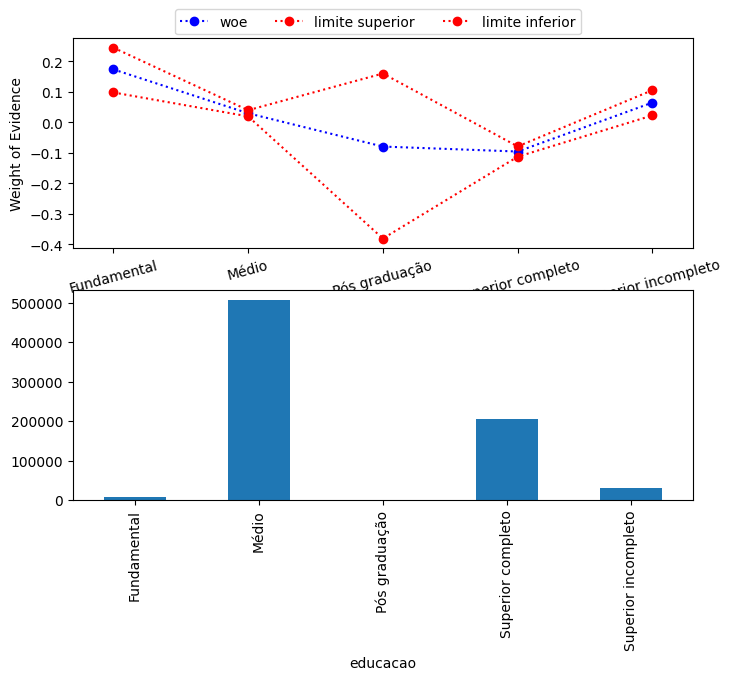

In [22]:
biv_discreta('educacao', df)

In [23]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

C:\Users\AJWork\AppData\Local\Temp\ipykernel_3068\707398857.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


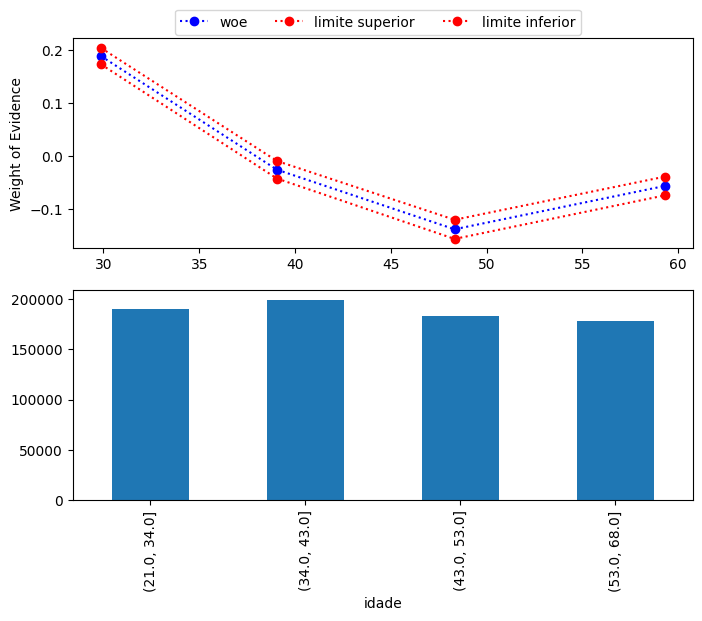

In [24]:
biv_continua('idade', 4, df)

In [25]:
df.tempo_emprego.describe()

count    750000.000000
mean          6.279315
std           6.921453
min          -1.000000
25%           1.183562
50%           4.690411
75%           9.090411
max          42.906849
Name: tempo_emprego, dtype: float64

C:\Users\AJWork\AppData\Local\Temp\ipykernel_3068\707398857.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


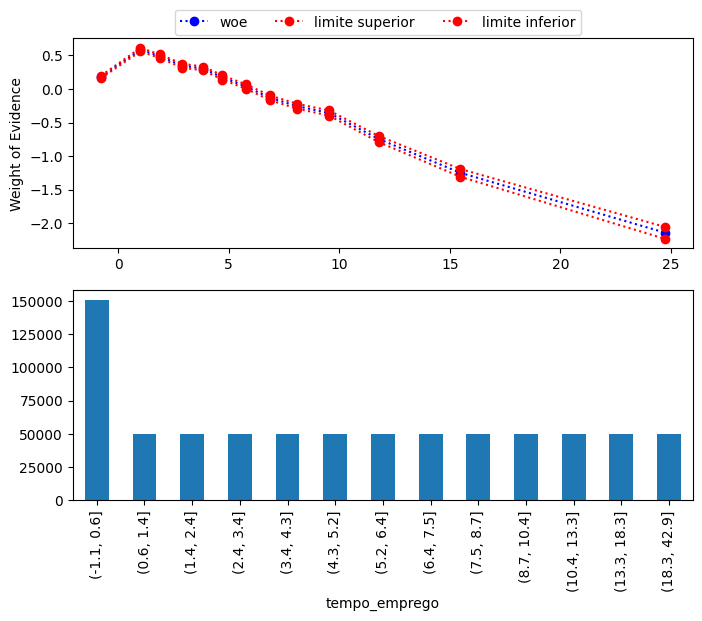

In [26]:
df.loc[df['tempo_emprego']<0,'tempo_emprego'] = -1
biv_continua('tempo_emprego', 15, df)

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [28]:
df.isna().mean()

data_ref                 0.0
index                    0.0
sexo                     0.0
posse_de_veiculo         0.0
posse_de_imovel          0.0
qtd_filhos               0.0
tipo_renda               0.0
educacao                 0.0
estado_civil             0.0
tipo_residencia          0.0
idade                    0.0
tempo_emprego            0.0
qt_pessoas_residencia    0.0
renda                    0.0
mau                      0.0
bom                      0.0
dtype: float64

In [29]:
metadados.sort_values(by='IV', ascending=False)

,dtype,nmissing,valores_unicos,papel,IV
renda,float64,0.0,142419.0,covariavel,1.068628
data_ref,datetime64[ns],0.0,15.0,covariavel,0.345982
tempo_emprego,float64,0.0,3005.0,covariavel,0.265434
idade,int64,0.0,47.0,covariavel,0.017968
posse_de_imovel,object,0.0,2.0,covariavel,0.009693
tipo_renda,object,0.0,5.0,covariavel,0.009360
educacao,object,0.0,5.0,covariavel,0.003547
tipo_residencia,object,0.0,6.0,covariavel,0.003045
index,int64,0.0,16650.0,covariavel,0.002664
sexo,object,0.0,2.0,covariavel,0.002185


In [30]:
' + '.join(list(metadados.sort_values(by='IV', ascending=False).index))

'renda + data_ref + tempo_emprego + idade + posse_de_imovel + tipo_renda + educacao + tipo_residencia + index + sexo + qt_pessoas_residencia + estado_civil + posse_de_veiculo + qtd_filhos + mau + bom'

In [31]:
# Selecionei as variaveis com maiores valores IV:
formula = '''
    mau ~ renda + tempo_emprego + idade + posse_de_imovel + tipo_renda
'''

rl = smf.glm(formula, data=df, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               750000
Model:                            GLM   Df Residuals:                   749991
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.8372e+05
Date:                Thu, 27 Mar 2025   Deviance:                   3.6724e+05
Time:                        18:19:37   Pearson chi2:                 4.66e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.05704
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.2680      0.022    -58.249      0.000      -1.311      -1.225
posse_de_imovel[T.S]              -0.0892      0.009     -9.622      0.000      -0.107      -0.071
tipo_renda[T.Bolsista]            -0.1738      0.268     -0.648      0.517      -0.700       0.352
tipo_renda[T.Empresário]          -0.0466      0.011     -4.193      0.000      -0.068      -0.025
tipo_renda[T.Pensionista]         -0.2405      0.018    -13.247      0.000      -0.276      -0.205
tipo_renda[T.Servidor público]    -0.0335      0.018     -1.819      0.069      -0.070       0.003
renda                             -0.0001   1.05e-06   -122.586      0.000      -0.000      -0.000
tempo_emprego                     -0.0264      0.001    -19.003      0.000      -0.029      -0.024
idade                              0.0006      0.001      1.140      0.254      -0.000       0.002
==================================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [33]:
# Gerando previsões
df_modelagem = df_modelagem.copy()
df_oot = df_oot.copy()

df_modelagem.loc[:, "score"] = rl.predict(df_modelagem)
df_oot.loc[:, "score"] = rl.predict(df_oot)

df_modelagem.loc[:, "score"] = rl.predict(df_modelagem)
df_oot.loc[:, "score"] = rl.predict(df_oot)

# Avaliação
def avaliar(df, nome_base):
    y_true = df["mau"]
    y_score = df["score"]
    y_pred = (y_score > 0.5).astype(int)

    acc = metrics.accuracy_score(y_true, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    auc = metrics.auc(fpr, tpr)
    gini = 2 * auc - 1
    ks = ks_2samp(df[df.mau == 1]["score"], df[df.mau == 0]["score"]).statistic

    return {
        "Base": nome_base,
        "Acurácia": acc,
        "AUC": auc,
        "Gini": gini,
        "KS": ks
    }

# Avaliaçao ambas as bases
resultado_modelagem = avaliar(df_modelagem, "Desenvolvimento")
resultado_oot = avaliar(df_oot, "Out of Time")

# Resultados
resultados = pd.DataFrame([resultado_modelagem, resultado_oot])
resultados

,Base,Acurácia,AUC,Gini,KS
0,Desenvolvimento,0.938928,0.767510,0.535019,0.395644
1,Out of Time,0.853333,0.728506,0.457012,0.334489


## Criar um pipeline utilizando o sklearn pipeline 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [37]:
# Os valores nulos foram tratados anteriormente. Os valores missing de tempo_emprego(numerico) foram substituidos por -1
df.isna().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
bom                      0
dtype: int64

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

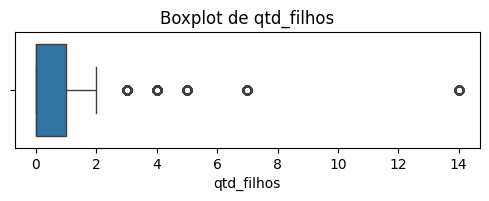

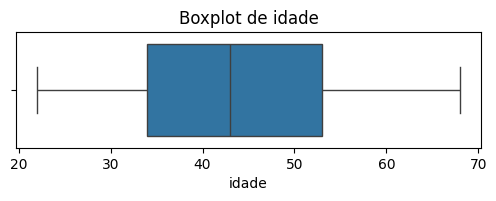

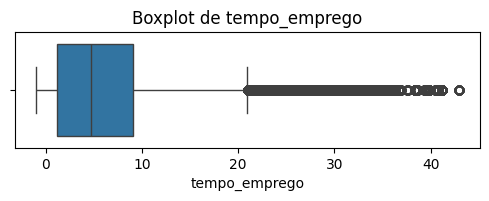

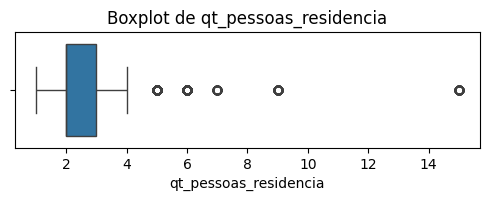

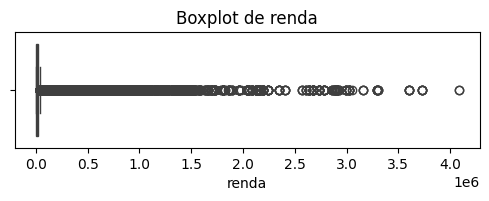

In [39]:
# Boxplot para identificacao de outliers
for col in variaveis_quantitativas:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

In [40]:
#Tratamento de outliers do qtd_filhos limitando valores fora do intervalo aceitavel
Q1 = df['qtd_filhos'].quantile(0.25)
Q3 = df['qtd_filhos'].quantile(0.75)
IQR = Q3 - Q1

limite_superior = Q3 + 1.5 * IQR

# Capando os valores acima do limite
df['qtd_filhos'] = df['qtd_filhos'].clip(upper=limite_superior)

In [41]:
#Tratamento de outliers do tempo_emprego
Q1 = df['tempo_emprego'].quantile(0.25)
Q3 = df['tempo_emprego'].quantile(0.75)
IQR = Q3 - Q1

limite_superior = Q3 + 1.5 * IQR

# Capando os valores acima do limite
df['tempo_emprego'] = df['tempo_emprego'].clip(upper=limite_superior)


In [42]:
#Tratamento de outliers do qt_pessoas_residencia
Q1 = df['qt_pessoas_residencia'].quantile(0.25)
Q3 = df['qt_pessoas_residencia'].quantile(0.75)
IQR = Q3 - Q1

limite_superior = Q3 + 1.5 * IQR

# Capando os valores acima do limite
df['qt_pessoas_residencia'] = df['qt_pessoas_residencia'].clip(upper=limite_superior)

In [43]:
# Tranformacao de renda em log pra reduzir impacto de valores extremos
df['renda_log'] = np.log1p(df['renda'])

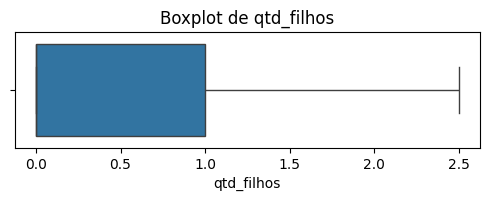

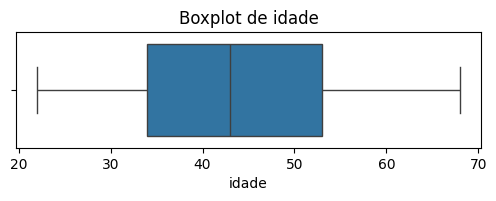

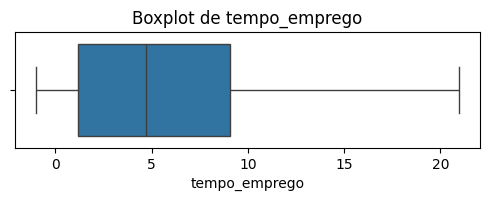

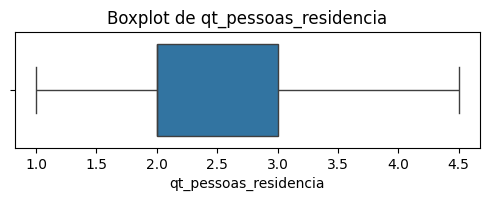

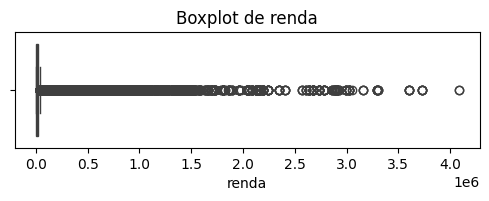

In [44]:
variaveis_quantitativas = ['qtd_filhos', 'idade', 'tempo_emprego',
                           'qt_pessoas_residencia', 'renda']
for col in variaveis_quantitativas:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [46]:
#IV (tecnica de Information Value) para seleçao de variaveis
metadados.sort_values(by='IV', ascending=False)

,dtype,nmissing,valores_unicos,papel,IV
renda,float64,0.0,142419.0,covariavel,1.068628
data_ref,datetime64[ns],0.0,15.0,covariavel,0.345982
tempo_emprego,float64,0.0,3005.0,covariavel,0.265434
idade,int64,0.0,47.0,covariavel,0.017968
posse_de_imovel,object,0.0,2.0,covariavel,0.009693
tipo_renda,object,0.0,5.0,covariavel,0.009360
educacao,object,0.0,5.0,covariavel,0.003547
tipo_residencia,object,0.0,6.0,covariavel,0.003045
index,int64,0.0,16650.0,covariavel,0.002664
sexo,object,0.0,2.0,covariavel,0.002185


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [48]:
df_modelagem_dummies = pd.get_dummies(df_modelagem, columns=variaveis_qualitativas, drop_first=True)
df_oot_dummies = pd.get_dummies(df_oot, columns=variaveis_qualitativas, drop_first=True)

In [49]:
X_train_dummies = df_modelagem_dummies.drop(columns=['data_ref', 'index', 'mau']).astype(int)
y_train = df_modelagem['mau']

X_test_dummies = df_oot_dummies.drop(columns=['data_ref', 'index', 'mau']).astype(int)
y_test = df_oot['mau']

print(f'X_train shape: {X_train_dummies.shape}')
print(f'X_test shape: {X_test_dummies.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (600000, 26)
X_test shape: (150000, 26)
y_train shape: (600000,)
y_test shape: (150000,)


### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [51]:
# Define a PCA to Linear dimensionality reduction
pca = PCA(n_components=5)

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=200)

In [52]:
#Dataset Treino
# "Fitando" e aplicando Z score nos dados de treino
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dummies)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_dummies.columns)

In [53]:
# "Fitando" e aplicando o pca nos dados de treino
X_train_pca = pca.fit_transform(X_train_scaled)
X_train_pca = pd.DataFrame(X_train_pca)

In [54]:
# "Fitando" e predizendo uma regressão logística nos dados de treino
logistic.fit(X_train_pca, y_train)

logistic.predict(X_train_pca)

array([False, False, False, ..., False, False, False])

In [55]:
#Dataset Test 
# Aplicando nos dados de teste o Z score "fitado" nos dados de treino  
pca.fit(X_test_dummies)
X_test_pca = pca.transform(X_test_dummies)  

In [56]:
# Predizendo nos dados de teste o modelo "fitado" nos dados de treino
logistic.predict(X_test_pca)

array([ True,  True, False, ...,  True,  True,  True])

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [58]:
# Colunas
num_cols = ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
cat_cols = ['posse_de_veiculo']

# Pipeline de pré-processamento numérico
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))  # reduz para 2 componentes
])

# Pipeline de pré-processamento categórico
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

# Junta tudo num ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Pipeline final
pipeline = Pipeline(steps=[
    ('preprocessamento', preprocessor),
    ('modelo', LogisticRegression())
])

In [59]:
pipeline.named_steps

{'preprocessamento': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('scaler', StandardScaler()),
                                                  ('pca', PCA(n_components=2))]),
                                  ['idade', 'tempo_emprego',
                                   'qt_pessoas_residencia', 'renda']),
                                 ('cat',
                                  Pipeline(steps=[('onehot',
                                                   OneHotEncoder(drop='first'))]),
                                  ['posse_de_veiculo'])]),
 'modelo': LogisticRegression()}

In [60]:
X_train = df_modelagem.drop(columns=['data_ref', 'index', 'mau'])
y_train = df_modelagem['mau']

X_test = df_oot.drop(columns=['data_ref', 'index', 'mau'])
y_test = df_oot['mau']

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (600000, 13)
X_test shape: (150000, 13)
y_train shape: (600000,)
y_test shape: (150000,)


### Treinar um modelo de regressão logistica com o resultado

In [62]:
model = pipeline.fit(X_train,y_train)
model

Pipeline(steps=[('preprocessamento',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['idade', 'tempo_emprego',
                                                   'qt_pessoas_residencia',
                                                   'renda']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['posse_de_veiculo'])])),
                ('modelo', LogisticRegression())])

### Salvar o pickle file do modelo treinado

In [64]:
import pickle

nome_arquivo = 'model_final.pkl'
pickle.dump(model, open(nome_arquivo, 'wb'))

# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [66]:
from pycaret.classification import *

In [67]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [68]:
df.shape

(750000, 15)

In [69]:
df.columns

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau'],
      dtype='object')

In [70]:
dataset = df.sample(50000)

In [71]:
dataset.drop(['data_ref','index'], axis=1, inplace=True)

In [72]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (47500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (2500, 13)


# Configurando o pycaret

In [74]:
exp_clf101 = setup(data = data, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(47500, 30)"
5,Transformed train set shape,"(33250, 30)"
6,Transformed test set shape,"(14250, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,17.0%


In [75]:
data.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                         bool
dtype: object

In [76]:
#forçando a variável qnt de filhos como numérica
data.qtd_filhos = data.qtd_filhos.astype(float)

In [77]:
exp_clf101 = setup(data = data, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(47500, 30)"
5,Transformed train set shape,"(33250, 30)"
6,Transformed test set shape,"(14250, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,17.0%


In [78]:
# Comparando todos os modelos
best_model = compare_models(fold=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9228,0.7721,0.0000,0.0000,0.0000,0.0000,0.0000,2.2420
ridge,Ridge Classifier,0.9228,0.6413,0.0000,0.0000,0.0000,0.0000,0.0000,0.1180
ada,Ada Boost Classifier,0.9228,0.7756,0.0144,0.6044,0.0280,0.0237,0.0795,0.4360
lda,Linear Discriminant Analysis,0.9228,0.6413,0.0000,0.0000,0.0000,0.0000,0.0000,0.1490
dummy,Dummy Classifier,0.9228,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1060
lightgbm,Light Gradient Boosting Machine,0.9221,0.7723,0.0257,0.4400,0.0484,0.0400,0.0904,0.2860
gbc,Gradient Boosting Classifier,0.9220,0.7773,0.0226,0.3933,0.0427,0.0348,0.0789,1.0620
catboost,CatBoost Classifier,0.9206,0.7620,0.0483,0.3862,0.0857,0.0698,0.1140,5.4560
xgboost,Extreme Gradient Boosting,0.9200,0.7463,0.0507,0.3629,0.0886,0.0713,0.1115,0.2240
knn,K Neighbors Classifier,0.9166,0.6383,0.0869,0.3396,0.1383,0.1105,0.1396,0.5240


In [79]:
print(best_model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [80]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [81]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9215,0.7667,0.0312,0.3810,0.0578,0.0466,0.0909
1,0.9191,0.7645,0.0078,0.1176,0.0147,0.0051,0.0109
2,0.9236,0.7751,0.0273,0.5833,0.0522,0.0457,0.1143
3,0.9224,0.8029,0.0195,0.4167,0.0373,0.0306,0.0767
4,0.9215,0.7720,0.0350,0.4091,0.0645,0.0530,0.1014
5,0.9224,0.7748,0.0233,0.4615,0.0444,0.0373,0.0901
6,0.9242,0.7624,0.0389,0.6667,0.0735,0.0656,0.1486
7,0.9215,0.7400,0.0233,0.3750,0.0440,0.0352,0.0775
8,0.9215,0.7807,0.0272,0.3889,0.0509,0.0412,0.0861


In [82]:
tuned_lightgbm = tune_model(lightgbm, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9056,0.7214,0.0898,0.2212,0.1278,0.0872,0.0972
1,0.9053,0.7373,0.0430,0.1358,0.0653,0.0294,0.0349
2,0.9068,0.7373,0.0508,0.1625,0.0774,0.0423,0.0504
3,0.9068,0.7358,0.0742,0.2065,0.1092,0.0714,0.0820
4,0.9125,0.7239,0.1128,0.3152,0.1662,0.1308,0.1503
5,0.9116,0.7169,0.0778,0.2597,0.1198,0.0872,0.1052
6,0.9083,0.7156,0.0661,0.2073,0.1003,0.0653,0.0774
7,0.9098,0.7127,0.0623,0.2133,0.0964,0.0637,0.0774
8,0.9050,0.7369,0.0700,0.1895,0.1023,0.0632,0.0720


Fitting 10 folds for each of 10 candidates, totalling 100 fits


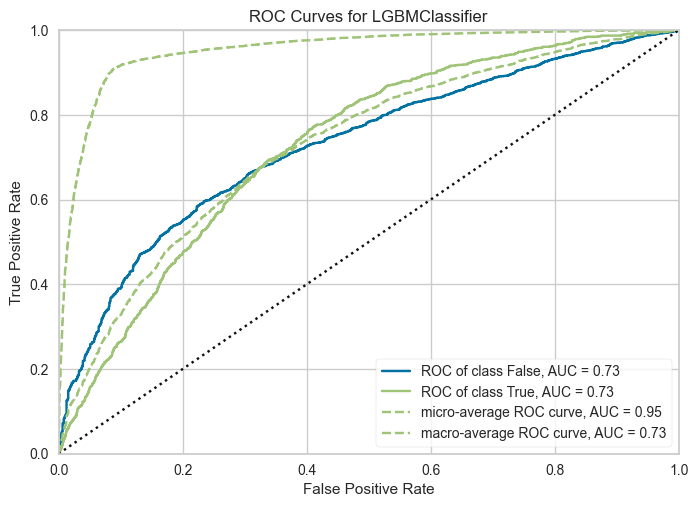

In [83]:
#Auc Plot
plot_model(tuned_lightgbm, plot = 'auc')

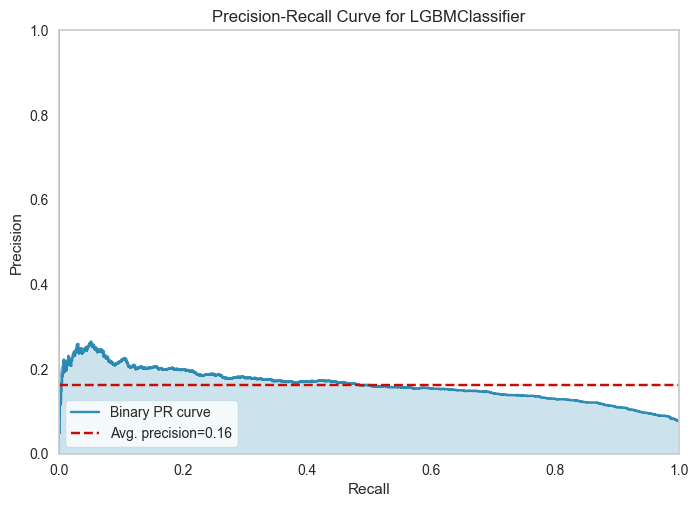

In [84]:
#Precision-Recall Plot
plot_model(tuned_lightgbm, plot = 'pr')

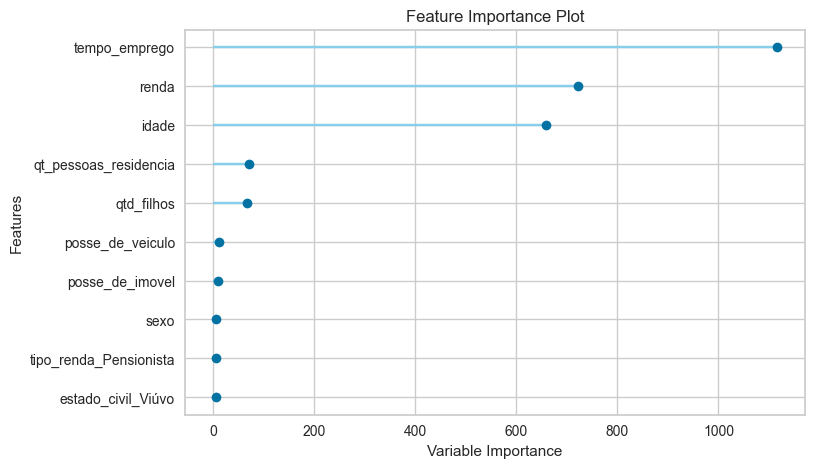

In [85]:
# Importância das variáveis (Feature Importance) Plot
plot_model(tuned_lightgbm, plot='feature')

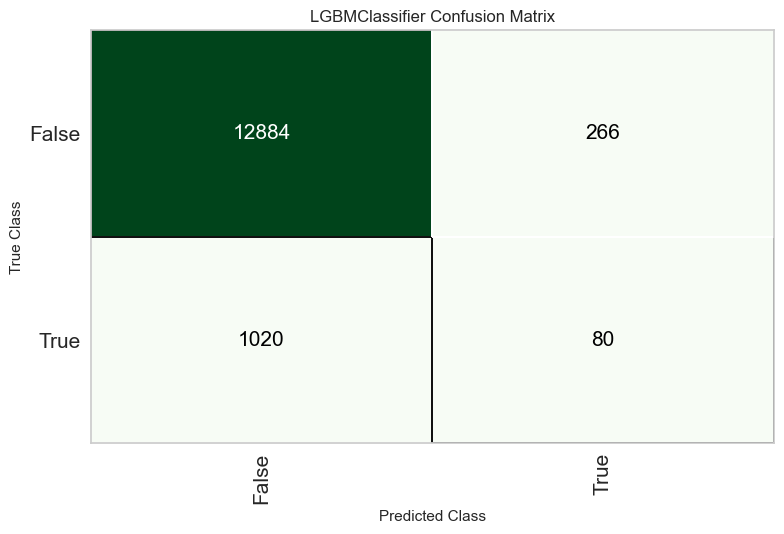

In [86]:
#Matriz de Confusao 
plot_model(tuned_lightgbm, plot = 'confusion_matrix')

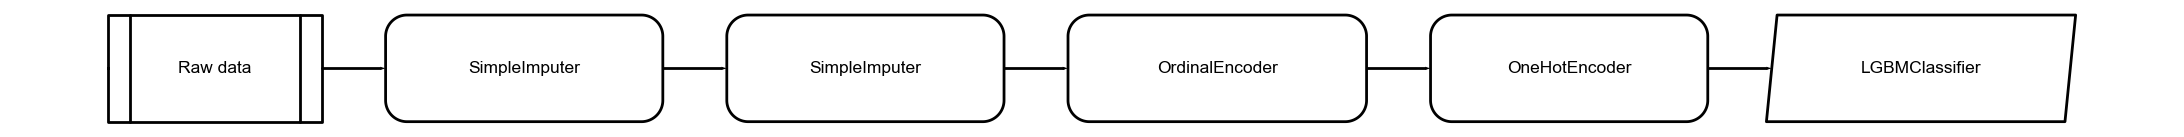

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [87]:
evaluate_model(tuned_lightgbm)

In [88]:
#Predict na amostra de validação / hold-out 
predict_model(tuned_lightgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9098,0.7293,0.0727,0.2312,0.1107,0.0765,0.0910


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [89]:
#Finalizando o modelo para deploy 
final_lightgbm = finalize_model(tuned_lightgbm)

In [90]:
#Parâmetros finais do modelo Random Forest para deploy
print(tuned_lightgbm)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=20, n_jobs=-1, num_leaves=150, objective=None,
               random_state=123, reg_alpha=0.005, reg_lambda=0.0005,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


# Predizendo o conjunto de dados que não foi usado no treino

In [92]:
unseen_predictions = predict_model(final_lightgbm, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9136,0.7664,0.0423,0.1860,0.0690,0.0421,0.0553


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,F,N,S,0,Pensionista,Médio,Casado,Casa,55,NaN,2.0,7011.220215,False,0,0.9538
1,M,S,N,0,Empresário,Médio,Casado,Casa,45,2.219178,2.0,2792.870117,False,0,0.8420
2,M,S,N,2,Assalariado,Médio,Casado,Casa,35,0.594521,4.0,3860.300049,False,0,0.9374
3,F,N,N,0,Pensionista,Médio,Viúvo,Casa,65,NaN,1.0,5121.689941,False,0,0.9274
4,F,N,S,0,Servidor público,Médio,Casado,Casa,51,17.419178,2.0,15301.410156,False,0,0.9980


In [93]:
unseen_predictions.dtypes

sexo                     category
posse_de_veiculo         category
posse_de_imovel          category
qtd_filhos                   int8
tipo_renda               category
educacao                 category
estado_civil             category
tipo_residencia          category
idade                        int8
tempo_emprego             float32
qt_pessoas_residencia     float32
renda                     float32
mau                          bool
prediction_label            int32
prediction_score          float64
dtype: object

### Salvar o arquivo do modelo treinado

In [95]:
save_model(final_lightgbm,'Final LIGHTGBM Model 27Mar2025')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight=None,
            